# Quantum coined walk

In [74]:
from qiskit import *
import numpy as np
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.gate import *
import matplotlib.pyplot as plt
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit import Gate

## Useful gates

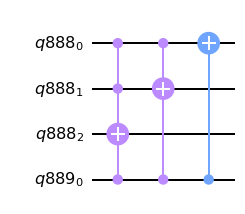

In [75]:
def increment_gate(n, m=1):
    q_r = QuantumRegister(n)
    q_c = QuantumRegister(m)
    inc = QuantumCircuit(q_r, q_c, name='Inc')
    for i in range(n-1,0, -1):
        inc.mct(q_r[:i]+q_c[:], q_r[i])
    inc.mct(q_c[:], q_r[0])
    
    return inc

increment_gate(3).draw(output ='mpl')

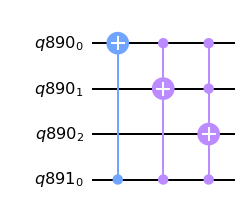

In [76]:
def decrement_gate(n, m=1):
    q_r = QuantumRegister(n)
    q_c = QuantumRegister(m)
    dec = QuantumCircuit(q_r, q_c, name='Dec')
    
    dec.mct(q_c[:], q_r[0])
    for i in range(1,n):
        dec.mct(q_r[:i]+q_c[:], q_r[i])
        
    return dec

decrement_gate(3).draw(output ='mpl')

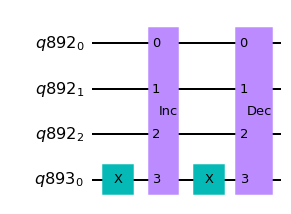

In [77]:
def shift_gate(n):
    q_r = QuantumRegister(n)
    q_c = QuantumRegister(1)
    shift = QuantumCircuit(q_r, q_c, name='Shift')
    
    shift.x( q_c[0])
    shift.append(increment_gate(n), q_r[:] + q_c[:])
    shift.x( q_c[0])
    shift.append(decrement_gate(n), q_r[:] + q_c[:])
    
    return shift

shift_gate(3).draw(output ='mpl')

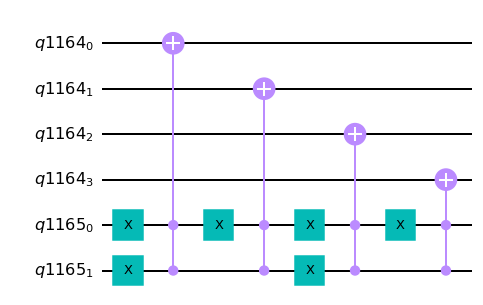

In [95]:
def grover_shift_gate(n,m):
    q_r = QuantumRegister(n)
    q_c = QuantumRegister(m)
    shift = QuantumCircuit(q_r, q_c, name = '$Shift_{Grover}$')
    
    for i in range(n):
        shift.x(q_c[0])
        if i%2==0:
            shift.x(q_c[1])
        shift.ccx(q_c[0],q_c[1],i)

    
    
    return shift

grover_shift_gate(4,2).draw(output ='mpl')

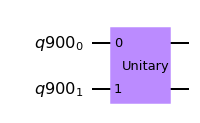

In [79]:
def grover_coin():

    q_c = QuantumRegister(2)
    coin = QuantumCircuit(q_c, name = '$G_{coin}$')

    G = Operator(np.array([
        [-1, 1, 1, 1],
        [1, -1, 1, 1],
        [1, 1, -1, 1],
        [1, 1, 1, -1]
    ])/2)

    coin.unitary(G, q_c[:])
    return coin

grover_coin().draw(output ='mpl')

## Useful functions

In [80]:
def simulate(circuit):
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend = simulator).result()
    counts = result.get_counts(circuit)
    return counts

In [81]:
def prob(k,u):
    if u== 0:
        if k==0 :
            return (1,0)
        return (0,0)
    A_0, B_0 = prob(k-1,u-1)
    A_1, B_1 = prob(k+1,u-1)
    return ((A_0+B_0)/2**(0.5) , (A_1-B_1)/2**(0.5))

In [128]:
def show_dec_bar(t,n,counts, m=1):
    x= range(-t, t+1)
    y= [0]*(2*t+1)
    for num in list(counts.keys()) :
        no = int(num[m+1:], base = 2)
        no = no if no<=2**(n-1) else no-(2**n)
        y[no+t]+= counts[num]
    y=np.array(y)/sum(y)

    plt.bar(x,y, alpha = 1)

## Coined walk with $|+>$ coin

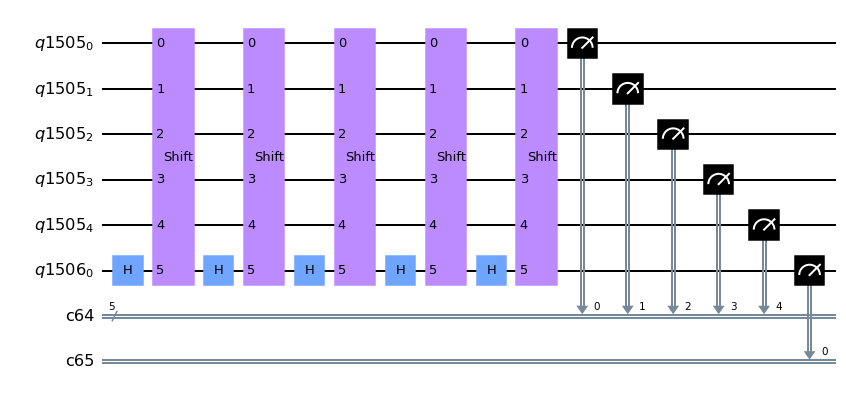

In [124]:
t = 5
n = 5
q_reg = QuantumRegister(n)
q_coin = QuantumRegister(1)
c_reg = ClassicalRegister(n)
c_coin = ClassicalRegister(1)

circuit = QuantumCircuit(q_reg, q_coin, c_reg, c_coin )

for _ in range(t):
    circuit.h(q_coin[0])
    circuit.append(shift_gate(n), q_reg[:] + q_coin[:])

circuit.measure(q_reg, c_reg )
circuit.measure(q_coin, c_coin )

circuit.draw(output ='mpl')

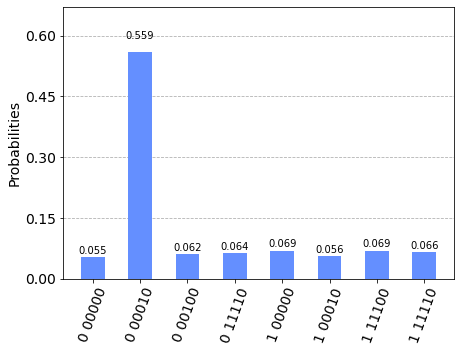

In [122]:
counts = simulate(circuit)
plot_histogram(counts)

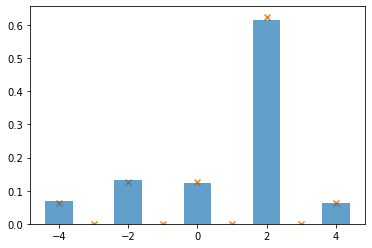

In [123]:
show_dec_bar(t,n,counts)


X=range(-t,t+1)
Y=[(prob(i,t)[0]**2 +prob(i,t)[1]**2) for i in range(-t,t+1)]

plt.scatter(X,Y, marker='x')


plt.savefig('+_5.png')


![SegmentLocal](Hadamard_+_coin.gif "segment")

## Coined walk with $|->$ coin

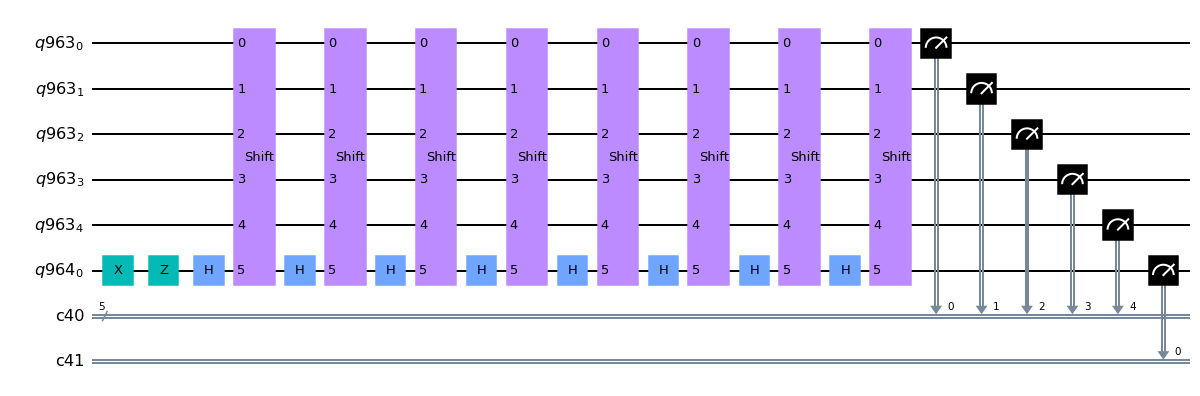

In [86]:
t = 8
n = 5
q_reg = QuantumRegister(n)
q_coin = QuantumRegister(1)
c_reg = ClassicalRegister(n)
c_coin = ClassicalRegister(1)

circuit = QuantumCircuit(q_reg, q_coin, c_reg, c_coin )

circuit.x(q_coin[:])
circuit.z(q_coin[:])

for _ in range(t):
    circuit.h(q_coin[0])
    circuit.append(shift_gate(n), q_reg[:] + q_coin[:])

circuit.measure(q_reg, c_reg )
circuit.measure(q_coin, c_coin )


circuit.draw(output ='mpl')

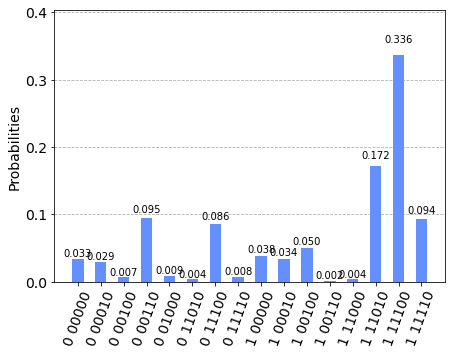

In [87]:
counts = simulate(circuit)
plot_histogram(counts)

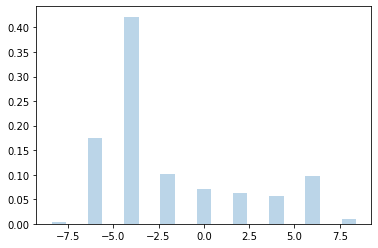

In [88]:
show_dec_bar(t,n,counts)

![SegmentLocal](Hadamard_-_coin.gif "segment")

## Balanced coin

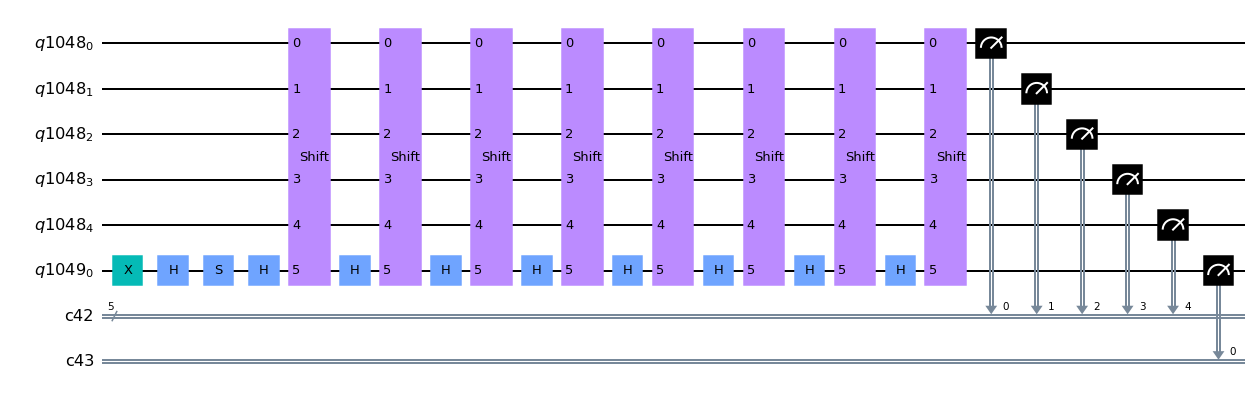

In [89]:
t = 8
n = 5
q_reg = QuantumRegister(n)
q_coin = QuantumRegister(1)
c_reg = ClassicalRegister(n)
c_coin = ClassicalRegister(1)

circuit = QuantumCircuit(q_reg, q_coin, c_reg, c_coin )

circuit.x(q_coin[:])
circuit.h(q_coin[:])
circuit.s(q_coin[:])

for _ in range(t):
    circuit.h(q_coin[0])
    circuit.append(shift_gate(n), q_reg[:] + q_coin[:])

circuit.measure(q_reg, c_reg )
circuit.measure(q_coin, c_coin )


circuit.draw(output ='mpl')

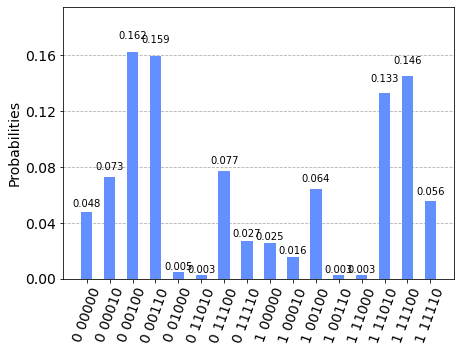

In [90]:
counts = simulate(circuit)
plot_histogram(counts)

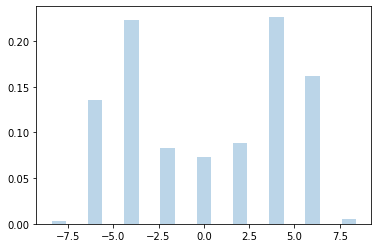

In [91]:
show_dec_bar(t,n,counts)

## with grover's diffusion coin

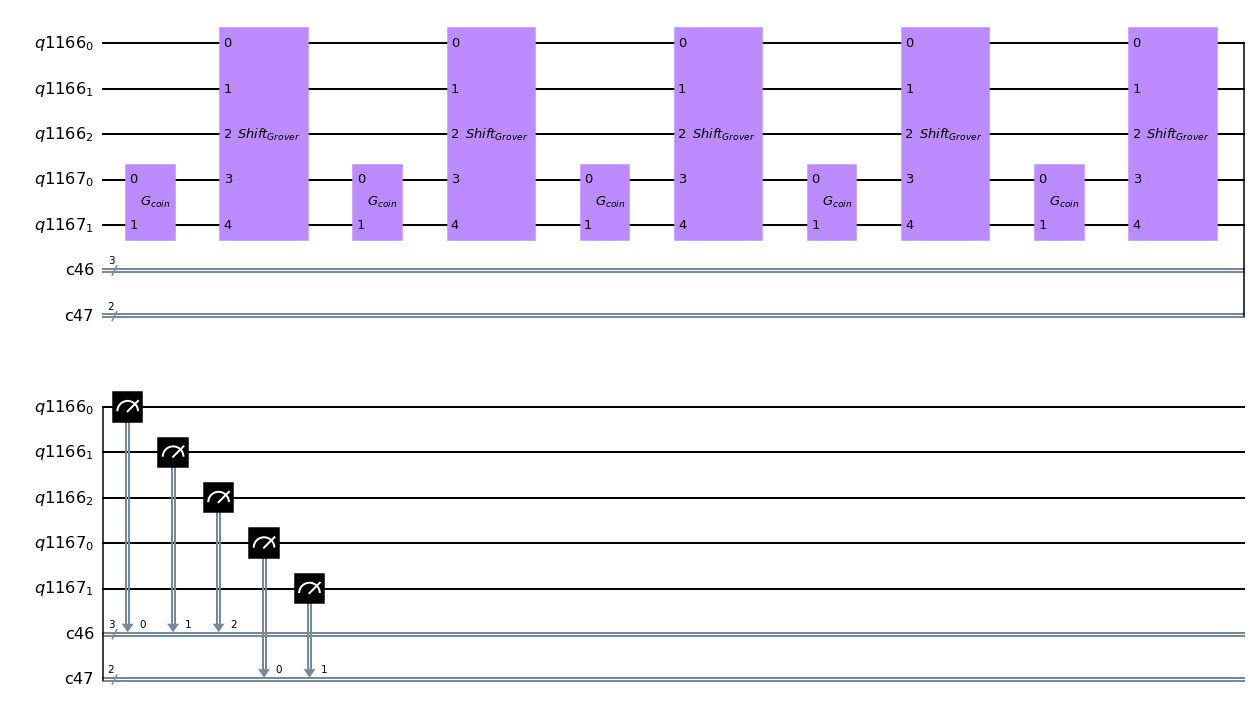

In [96]:
t = 5
n = 3
q_reg = QuantumRegister(n)
q_coin = QuantumRegister(m)
c_reg = ClassicalRegister(n)
c_coin = ClassicalRegister(m)

circuit = QuantumCircuit(q_reg, q_coin, c_reg, c_coin )

for _ in range(t):
    # Coin operator
    circuit.append(grover_coin(), q_coin[:])
    
    circuit.append(grover_shift_gate(n,m), q_reg[:] + q_coin[:])

circuit.measure(q_reg, c_reg )
circuit.measure(q_coin, c_coin )


circuit.draw(output ='mpl')

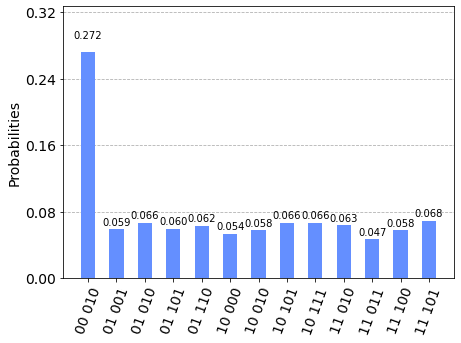

In [93]:
counts = simulate(circuit)
plot_histogram(counts)

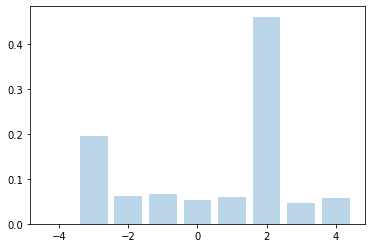

In [94]:
show_dec_bar(2**(n-1),n,counts,2)